### Libraries

In [150]:
import json
import requests
import urllib.parse
import pandas as pd
import matplotlib.pyplot as plt
from textwrap import wrap
from datetime import date

today_str = date.today().strftime('%d-%b-%y')

### Requests

In [24]:
base_url = 'https://m00m3rfw1a-dsn.algolia.net/1/indexes/*/queries'
params = {
    'x-algolia-agent': 'Algolia for JavaScript (4.5.1); Browser (lite)',
    'x-algolia-api-key': '97780d6ca6d719cafd5ef2556417e2ce',
    'x-algolia-application-id': 'M00M3RFW1A'
}

request_url = f"{base_url}?{urllib.parse.urlencode(params)}"

headers = {
    'Accept': '*/*',
    'Accept-Language': 'en-GB,en;q=0.9,en-US;q=0.8,bs;q=0.7,hr;q=0.6',
    'Connection': 'keep-alive',
    'Origin': 'https://shop.pimoroni.com',
    'Referer': 'https://shop.pimoroni.com/',
    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'cross-site',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36',
    'content-type': 'application/x-www-form-urlencoded',
    'sec-ch-ua': '"Chromium";v="116", "Not)A;Brand";v="24", "Google Chrome";v="116"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
}

In [237]:
collections = [
    "Raspberry Pi",
    "Raspberry Pi Pico",
    "Feather by Adafruit",
    "Kits",
    "Components",
    "Tools",
    "Kids"
]

# "Breakouts, Boards & Electronics",
collections = sorted(collections,key=len,reverse=True)

In [26]:
def request_response(request_url,headers,hits,facet):
    form_data = {
        'requests': [
            {
                'indexName': 'shop.pimoroni.com.variants',
                'query': '',
                'params': f'facetFilters=[["collections:{facet}"]]&hitsPerPage={hits}&page=0&attributesToRetrieve=["id","product_id","handle","retired","product_title","variant_title","description_first_paragraph","image","hidden_tags","price_ex_vat","compare_price_ex_vat","taxable","in_stock","rating","review_count","pre_order","special"]'
            }
        ]
    }
    response = requests.post(request_url, json=form_data, headers=headers)
    response_dict = json.loads(response.text)
    df_response = pd.DataFrame.from_dict(response_dict,orient='columns')
    return df_response

In [27]:
def hits_counter(df_response):
    hits_dict = df_response.loc[0,'results']
    df_hits = pd.json_normalize(hits_dict)
    hits = df_hits.loc[0,'nbHits']
    print("Number of hits against facet: ",hits)
    return hits

In [28]:
def base_table(request_url,headers,hits,facet):
    df_json = request_response(request_url,headers,hits,facet)
    result_dict_list = df_json.loc[0,'results']
    df_hits = pd.json_normalize(result_dict_list)
    list_of_products = df_hits.loc[0,'hits']
    df_base = pd.json_normalize(list_of_products)
    return df_base

In [29]:
def prune_cols(df):
    cols = [
            'id',
            'product_id',
            'product_title',
            'variant_title',
            'price_ex_vat',
            '_highlightResult.product_type.value',
            '_highlightResult.vendor.value',
            'image'
            ]
    df_products = df.copy()
    df_products = df_products[cols]
    df_products.rename(columns={
        "_highlightResult.product_type.value":"product_type",
        "_highlightResult.vendor.value":"vendor",
        "price_ex_vat":"price"
    },inplace=True)
    df_products['price'] = df_products['price']*1.2
    return df_products

In [30]:
def facet_products(request_url,headers,facet):
    # Extracting Number of Product Hits First
    df_response = request_response(request_url,headers,1,facet)
    hits = hits_counter(df_response)

    # Get all products of a given facet
    df = base_table(request_url,headers,hits,facet)
    df_products = prune_cols(df)
    return df_products

In [31]:
for i,facet in enumerate(collections):
    print(i,facet)
    if i == 0 :
        df_products = facet_products(request_url,headers,facet)
    if i != 0:
        df_facet = facet_products(request_url,headers,facet)
        df_products = pd.concat([df_products,df_facet])

0 Raspberry Pi
Number of hits against facet:  534
1 Raspberry Pi Pico
Number of hits against facet:  137
2 Feather by Adafruit
Number of hits against facet:  130
3 Kits
Number of hits against facet:  93
4 Components
Number of hits against facet:  628
5 Tools
Number of hits against facet:  106
6 Kids
Number of hits against facet:  66


### Grouping

In [32]:
df_products.reset_index().drop(columns="index")
df_products.drop_duplicates(subset=['id'],inplace=True)

In [33]:
df_products[:3]

,id,product_id,product_title,variant_title,price,product_type,vendor,image
0,31856486416467,3855360327763,Raspberry Pi 4 Model B,8GB RAM,74.94,Raspberry Pi,Raspberry Pi,https://cdn.shopify.com/s/files/1/0174/1800/pr...
1,29157087445075,3855360327763,Raspberry Pi 4 Model B,4GB RAM,54.96,Raspberry Pi,Raspberry Pi,https://cdn.shopify.com/s/files/1/0174/1800/pr...
2,39862027190355,3876163977299,Picade,"Amazebundle: Picade + Pi4 8GB, PSU, and 32GB SD",249.00,Arcade,Pimoroni,https://cdn.shopify.com/s/files/1/0174/1800/pr...


In [53]:
df_vendor_count = df_products.groupby(['vendor'])['id'].count().reset_index(name='count').sort_values(by='count',ascending=False)
df_vendor_count[:3]

,vendor,count
33,Other,349
39,Pimoroni,269
3,Adafruit,233


### Visualization

In [346]:
def bar_viz(df,col,title_mod):
        # Grouping Elements
        top = 15
        df = df_products.groupby([col])['id'].count().reset_index(name='count')
        df = df.sort_values(by='count',ascending=False).head(top)
        col_newlines = ['\n'.join(wrap(open,12)) for i,open in enumerate(df[col][0:top])]

        # Creating Colormap
        cmap = plt.get_cmap('summer_r')
        # norm = plt.Normalize(df['count'].min(),df['count'].max())
        # colors = cmap(norm(df['count']))

        # Drawing Chart
        fig, ax = plt.subplots(figsize=(12,5),edgecolor='darkslategrey',linewidth=2)
        ax.bar(df[col],df['count'],color=cmap(df['count']),edgecolor='darkslategrey',lw=1.5)
        ax.set_title(f'Top {top} {title_mod} | Pimoroni', loc='left',fontsize=14)

        # Background Color
        fig.set_facecolor('white')

        # Annotations
        top_label_y = 1.05
        anno_separation = 0.07
        ax.text(x=0.995, y=top_label_y, s=f'Data refreshed: {today_str}', transform=ax.transAxes, va='top', ha='right')
        ax.text(x=0.995, y=top_label_y-anno_separation, s=f'Website Analysed: Pimoroni.com', transform=ax.transAxes, va='top', ha='right')

        collect_str = ""
        collect_str = collect_str.join([ele+"\n" if i < len(collections) else ele for i,ele in enumerate(collections,start=1)])
        collect_str = "Collections Analysed:\n\n" + collect_str

        # Collections Box and Text
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.85, 0.725, 
                collect_str, 
                transform=ax.transAxes, 
                fontsize=10,
                va='top', 
                ha='left',
                bbox=props
                )

        # Wrapping and Spacing X-Ticks
        ax.set_xticklabels(col_newlines)
        for i,count in enumerate(df['count']):
            ax.text(i,count,int(count),
                    fontsize=12,
                    color='white',
                    weight='bold',
                    bbox=dict(fc=(.2, .4, .3), lw=1.5, pad=0.5),
                    va='bottom',
                    ha='center'
                    )
        for tick in ax.xaxis.get_major_ticks()[1::2]:
            tick.set_pad(20)

        plt.tight_layout()

        plt.savefig(
             f'charts/{col}.png',
             edgecolor = 'darkslategrey',
             dpi=150
        )

C:\Users\Filip\AppData\Local\Temp\ipykernel_15620\3785309482.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(col_newlines)


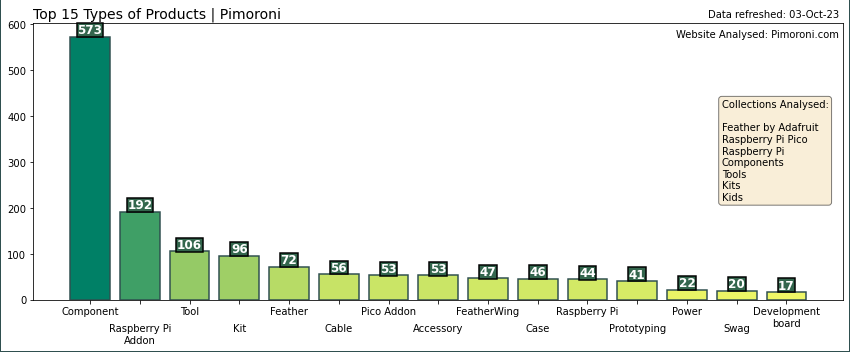

In [347]:
bar_viz(
    df_products,
    'product_type',
    'Types of Products'
    )

C:\Users\Filip\AppData\Local\Temp\ipykernel_15620\3785309482.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(col_newlines)


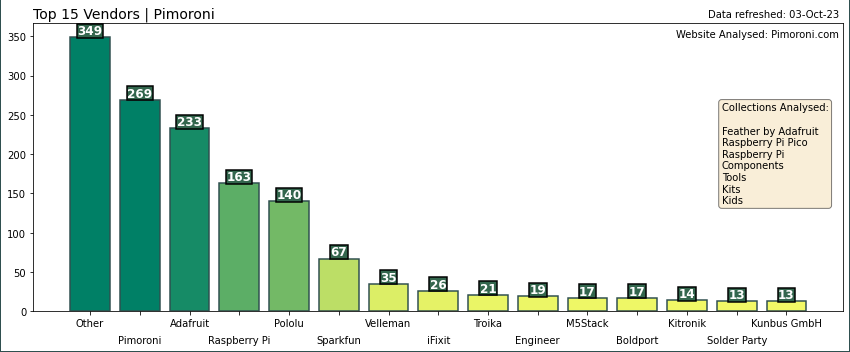

In [348]:
bar_viz(
    df_products,
    'vendor',
    'Vendors'
)
    